# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

## Checking GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Creating the Datasets

Define paramters for the data loaders

In [3]:
batch_size = 16
img_height = 48
img_width = 48
color_mode = 'grayscale' # One of "grayscale", "rgb", "rgba".
validation_split = 0.2

dataset = "CK+48" # One of "CK+" , "FER_2013"

train_data = "data/"+ dataset + "/train/"
test_data = "data/"+ dataset + "/test/"

print(train_data)
print(test_data)

data/CK+48/train/
data/CK+48/test/


Load the data into the datasets

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    shuffle=False,
    color_mode = color_mode,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 783 files belonging to 7 classes.
Using 627 files for training.
Found 783 files belonging to 7 classes.
Using 156 files for validation.
Found 198 files belonging to 7 classes.


View the classes in the dataset

In [5]:
class_names = test_ds.class_names
print(class_names)

['anger', 'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise']


## Configuring the Datset
Enable buffered prefetching so you can yield data from disk without having I/O become blocking

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [8]:
from tensorflow.keras.layers import Input, Conv2D , MaxPool2D, Flatten, Dense , Dropout
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

from cnn_models import *

model_names = ["VGG16" , "ResNet50_V1" , "ResNet50_V2" , "ResNet18_V1"]
model_name = model_names[3]


model = model_ResNet_V2(model="ResNet50", grayscale=True)

## Compile the model

In [9]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## View Model Summary

In [10]:
model.summary()

Model: "ResNet50_V2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 Conv1_Pad (ZeroPadding2D)      (None, 54, 54, 1)    0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['Conv1_Pad[1][0]']              
                                                                                                  
 MaxPool2D_1_Pad (ZeroPadding2D  (None, 26, 26, 64)  0           ['Conv1[1][0]']                  
 )                                                                                      

 Conv2_Block3_Pre-Activation_Re  (None, 12, 12, 256)  0          ['Conv2_Block3_Pre-Activation_BN[
 lu (Activation)                                                 1][0]']                          
                                                                                                  
 Conv2_Block3_1_Conv (Conv2D)   (None, 12, 12, 64)   16384       ['Conv2_Block3_Pre-Activation_Rel
                                                                 u[1][0]']                        
                                                                                                  
 Conv2_Block3_1_BN (BatchNormal  (None, 12, 12, 64)  48          ['Conv2_Block3_1_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv2_Block3_1_Relu (Activatio  (None, 12, 12, 64)  0           ['Conv2_Block3_1_BN[1][0]']      
 n)       

 Conv3_Block2_2_Conv (Conv2D)   (None, 6, 6, 128)    147456      ['Conv3_Block2_2_Pad[1][0]']     
                                                                                                  
 Conv3_Block2_2_BN (BatchNormal  (None, 6, 6, 128)   24          ['Conv3_Block2_2_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv3_Block2_2_Relu (Activatio  (None, 6, 6, 128)   0           ['Conv3_Block2_2_BN[1][0]']      
 n)                                                                                               
                                                                                                  
 Conv3_Block2_3_Conv (Conv2D)   (None, 6, 6, 512)    66048       ['Conv3_Block2_2_Relu[1][0]']    
                                                                                                  
 Conv3_Blo

 Conv4_Block1_1_Conv (Conv2D)   (None, 3, 3, 256)    131072      ['Conv4_Block1_Pre-Activation_Rel
                                                                 u[1][0]']                        
                                                                                                  
 Conv4_Block1_1_BN (BatchNormal  (None, 3, 3, 256)   12          ['Conv4_Block1_1_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv4_Block1_1_Relu (Activatio  (None, 3, 3, 256)   0           ['Conv4_Block1_1_BN[1][0]']      
 n)                                                                                               
                                                                                                  
 Conv4_Block1_2_Pad (ZeroPaddin  (None, 5, 5, 256)   0           ['Conv4_Block1_1_Relu[1][0]']    
 g2D)     

 Conv4_Block3_2_Relu (Activatio  (None, 3, 3, 256)   0           ['Conv4_Block3_2_BN[1][0]']      
 n)                                                                                               
                                                                                                  
 Conv4_Block3_3_Conv (Conv2D)   (None, 3, 3, 1024)   263168      ['Conv4_Block3_2_Relu[1][0]']    
                                                                                                  
 Conv4_Block3_Add_Output (Add)  (None, 3, 3, 1024)   0           ['Conv4_Block2_Add_Output[1][0]',
                                                                  'Conv4_Block3_3_Conv[1][0]']    
                                                                                                  
 Conv4_Block4_Pre-Activation_BN  (None, 3, 3, 1024)  12          ['Conv4_Block3_Add_Output[1][0]']
  (BatchNormalization)                                                                            
          

 n)                                                                                               
                                                                                                  
 Conv4_Block6_2_Pad (ZeroPaddin  (None, 5, 5, 256)   0           ['Conv4_Block6_1_Relu[1][0]']    
 g2D)                                                                                             
                                                                                                  
 Conv4_Block6_2_Conv (Conv2D)   (None, 2, 2, 256)    589824      ['Conv4_Block6_2_Pad[1][0]']     
                                                                                                  
 Conv4_Block6_2_BN (BatchNormal  (None, 2, 2, 256)   8           ['Conv4_Block6_2_Conv[1][0]']    
 ization)                                                                                         
                                                                                                  
 Conv4_Blo

 Conv5_Block2_Add_Output (Add)  (None, 2, 2, 2048)   0           ['Conv5_Block1_Add_Output[1][0]',
                                                                  'Conv5_Block2_3_Conv[1][0]']    
                                                                                                  
 Conv5_Block3_Pre-Activation_BN  (None, 2, 2, 2048)  8           ['Conv5_Block2_Add_Output[1][0]']
  (BatchNormalization)                                                                            
                                                                                                  
 Conv5_Block3_Pre-Activation_Re  (None, 2, 2, 2048)  0           ['Conv5_Block3_Pre-Activation_BN[
 lu (Activation)                                                 1][0]']                          
                                                                                                  
 Conv5_Block3_1_Conv (Conv2D)   (None, 2, 2, 512)    1048576     ['Conv5_Block3_Pre-Activation_Rel
          

Plot the the CNN Model

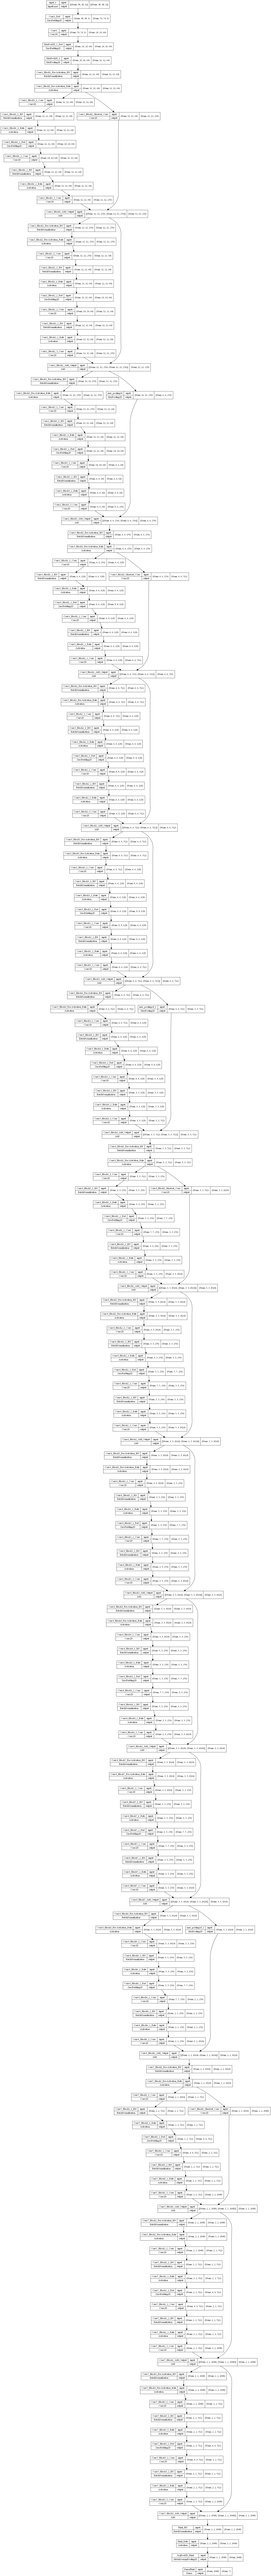

In [13]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 


plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png', width = 400)

## Train the Model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

name = [model_name, dataset , 'weights']
name = '_'.join(name) + ".hdf5"

checkpoint_file_path = "models/" + name


checkpoint = ModelCheckpoint(filepath=checkpoint_file_path,
                            monitor="val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode= "auto",
                            save_freq= "epoch",
                            options=None)


early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0, # Minimum change in the monitored quantity to qualify as an improvemen
                          patience=10, # Number of epochs with no improvement after which training will be stopped
                          verbose=1,
                          mode='auto')

In [15]:
epochs=100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [checkpoint,early_stop] 
)

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 2.0620 - accuracy: 0.2791
Epoch 1: val_loss improved from inf to 1.90386, saving model to models\ResNet18_V1_CK+48_weights.hdf5
40/40 [==============================] - 14s 195ms/step - loss: 2.0620 - accuracy: 0.2791 - val_loss: 1.9039 - val_accuracy: 0.2244
Epoch 2/300
40/40 [==============================] - ETA: 0s - loss: 1.4330 - accuracy: 0.4609
Epoch 2: val_loss improved from 1.90386 to 1.77731, saving model to models\ResNet18_V1_CK+48_weights.hdf5
40/40 [==============================] - 5s 139ms/step - loss: 1.4330 - accuracy: 0.4609 - val_loss: 1.7773 - val_accuracy: 0.3718
Epoch 3/300
40/40 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7002
Epoch 3: val_loss improved from 1.77731 to 1.66184, saving model to models\ResNet18_V1_CK+48_weights.hdf5
40/40 [==============================] - 5s 133ms/step - loss: 0.8121 - accuracy: 0.7002 - val_loss: 1.6618 - val_accuracy: 0.4615
Epoch 4

40/40 [==============================] - ETA: 0s - loss: 1.5973e-04 - accuracy: 1.0000
Epoch 28: val_loss did not improve from 0.03966
40/40 [==============================] - 3s 67ms/step - loss: 1.5973e-04 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.9808
Epoch 29/300
40/40 [==============================] - ETA: 0s - loss: 1.4410e-04 - accuracy: 1.0000
Epoch 29: val_loss did not improve from 0.03966
40/40 [==============================] - 3s 71ms/step - loss: 1.4410e-04 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 0.9808
Epoch 29: early stopping


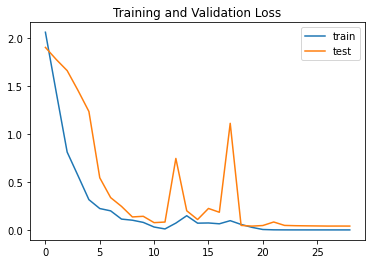

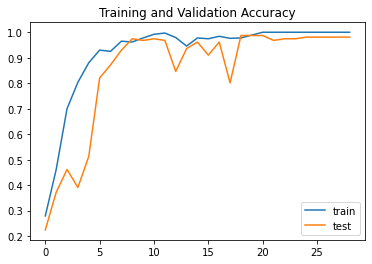

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(acc, label='train')
plt.plot(val_acc, label='test')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluate the Model

In [17]:
print("Evaluate")
model.load_weights(checkpoint_file_path) #Load the best weights from the file
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
13/13 [==============================] - 1s 48ms/step - loss: 0.0497 - accuracy: 0.9798


{'loss': 0.0497438982129097, 'accuracy': 0.9797979593276978}

## Confusion Matrix and Classification

              precision    recall  f1-score   support

       anger       0.96      0.93      0.94        27
     disgust       1.00      1.00      1.00        36
        fear       1.00      0.93      0.97        15
       happy       1.00      1.00      1.00        42
     neutral       1.00      1.00      1.00        11
     sadness       0.89      0.94      0.91        17
    surprise       0.98      1.00      0.99        50

    accuracy                           0.98       198
   macro avg       0.98      0.97      0.97       198
weighted avg       0.98      0.98      0.98       198



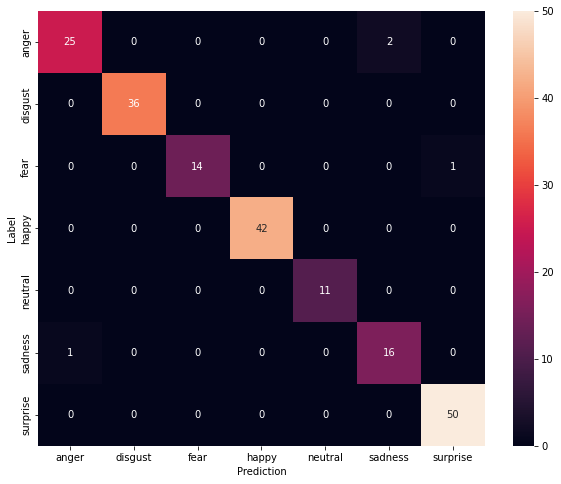

In [18]:
import seaborn as sns
from sklearn.metrics import classification_report

# defines which dataset we want to show the confusion matrix and classification report 
dataset = test_ds

predition_list = []
label_list = []

# Get predictions from the model
predictions = model.predict(dataset)
for prediction in predictions:
    predition_list.append(np.argmax(prediction))
    
# Get lables from the test set
labels = np.concatenate([y for x, y in dataset], axis=0)
for label in labels:
    label_list.append(np.argmax(label))
    
# create a confusion matrix
confusion_mtx = tf.math.confusion_matrix(label_list, predition_list , num_classes=7)

# Function that displays the confusion matrix
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


print(classification_report(label_list, predition_list, target_names=class_names))
show_confusion_matrix(confusion_mtx, class_names)
